In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

import yaml
import time
import glob
import gc
# from memory_profiler import profile

In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### uploading data

In [3]:
from transform_inputs import get_batch_yielder

In [4]:
batch_size = 300
batch_yielder = get_batch_yielder('data/ShuffleMergeSpectral_1.root', 'taus', batch_size)

In [5]:
%%timeit
for taus in batch_yielder:
    break

348 ms ± 36.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# getting one batch for tests
for taus in batch_yielder:
    break

In [7]:
taus

<Array [{run: 1, lumi: 41, evt: 40496, ... ] type='300 * {"run": uint32, "lumi":...'>

In [9]:
tau_i = 7 # tau index for tests

### define the grid

In [10]:
grid_types = ['inner', 'outer']
grid_dim = ['eta', 'phi']
grid_size, grid_left, grid_right = {}, {}, {}

In [11]:
n_cells = {'inner': 11, 'outer': 21}
cell_size = {'inner': 0.02, 'outer': 0.05}

In [12]:
for grid_type in grid_types:
    grid_size[grid_type] = cell_size[grid_type] * n_cells[grid_type]
    grid_left[grid_type], grid_right[grid_type] = - grid_size[grid_type] / 2, grid_size[grid_type] / 2

### derive constituents' features

In [13]:
from transform_inputs import add_vars_to_taus

In [14]:
constituent_types = ['ele', 'muon', 'pfCand']

In [15]:
# %%timeit
for c_type in constituent_types: 
    add_vars_to_taus(taus, c_type)

In [16]:
taus[tau_i]['n_ele'],  taus[tau_i]['n_muon'], taus[tau_i]['n_pfCand'],

(0, 0, 22)

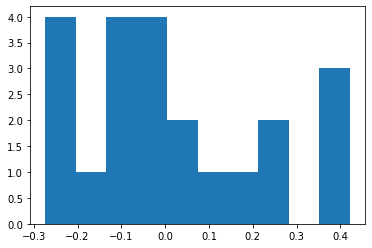

In [17]:
plt.hist(taus[tau_i]['pfCand', 'deta'])
plt.show()

### derive inner/outer grid masks

In [18]:
from transform_inputs import derive_grid_mask

In [19]:
# grid masks placeholder
grid_mask_dict = {key: {} for key in grid_types}

In [20]:
# %%timeit
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_mask_dict[grid_type][c_type] = derive_grid_mask(taus, c_type, grid_type)
    taus[c_type, 'inner_grid_mask'] = grid_mask_dict['inner'][c_type]
    taus[c_type, 'outer_grid_mask'] = grid_mask_dict['outer'][c_type] * (~grid_mask_dict['inner'][c_type])

In [21]:
for c_type in constituent_types:  
    for grid_type in grid_types:
        print(f'{c_type}: total {sum(taus[tau_i][c_type, f"{grid_type}_grid_mask"])} constituents in the {grid_type} cone for tau with i={tau_i}')
    print()

ele: total 0 constituents in the inner cone for tau with i=7
ele: total 0 constituents in the outer cone for tau with i=7

muon: total 0 constituents in the inner cone for tau with i=7
muon: total 0 constituents in the outer cone for tau with i=7

pfCand: total 2 constituents in the inner cone for tau with i=7
pfCand: total 20 constituents in the outer cone for tau with i=7



In [22]:
print(15*'*')
for c_type in constituent_types: 
    print()
    for grid_type in grid_types:  
        grid_mask = taus[c_type, f"{grid_type}_grid_mask"]
        print(f'{c_type}: total count of constituents per tau in the {grid_type} cone\n{ak.sum(grid_mask, axis=1)}')
        print()
    print(15*'*')

***************

ele: total count of constituents per tau in the inner cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ... 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

ele: total count of constituents per tau in the outer cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

muon: total count of constituents per tau in the inner cone
[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, ... 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]

muon: total count of constituents per tau in the outer cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]

***************

pfCand: total count of constituents per tau in the inner cone
[12, 3, 4, 2, 1, 1, 1, 2, 4, 1, 2, 5, 4, ... 4, 9, 10, 3, 5, 3, 8, 13, 4, 3, 2, 2, 2]

pfCand: total count of constituents per tau in the outer cone
[23, 9, 15, 41, 47, 15, 33, 20, 34, 26, 23, ... 5, 30, 25, 23, 31, 21, 34, 2, 16, 27]

***************


### derive cell indices 

In [23]:
from transform_inputs import derive_cell_indices

In [24]:
# %%timeit
for c_type in constituent_types: 
    for grid_type in grid_types:
        for dim in grid_dim:
            taus[c_type, f'{grid_type}_grid_indices_{dim}'] = derive_cell_indices(taus, c_type, grid_type, dim)

In [25]:
print(15*'*')
for c_type in constituent_types: 
    for grid_type in grid_types:      
        grid_mask = taus[c_type, f"{grid_type}_grid_mask"]
        print()
        print(f'{c_type}: eta indices of constituents for tau with i={tau_i} in the {grid_type} cone\n{taus[c_type, f"{grid_type}_grid_indices_eta"][grid_mask][tau_i]}')
    print(15*'*')

***************

ele: eta indices of constituents for tau with i=7 in the inner cone
[]

ele: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

muon: eta indices of constituents for tau with i=7 in the inner cone
[]

muon: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

pfCand: eta indices of constituents for tau with i=7 in the inner cone
[5, 0]

pfCand: eta indices of constituents for tau with i=7 in the outer cone
[11, 18, 7, 9, 8, 18, 7, 13, 15, 14, 17, 9, 8, 5, 15, 11, 9, 6, 5, 5]
***************


### validating indices

In [26]:
grid_type = 'outer'
c_type = 'pfCand'
tau_i = 10

In [27]:
grid_mask = taus[c_type, f'{grid_type}_grid_mask']
grid_coord = ak.to_pandas(taus[c_type, ['deta', 'dphi',]][grid_mask][tau_i])
grid_coord

,deta,dphi
entry,,
0,-0.233650,0.022859
1,-0.247566,0.144137
2,-0.232917,0.062595
3,-0.452467,0.123240
4,0.445875,0.053508
5,0.449904,0.191613
6,0.156194,0.397963
7,0.249580,-0.087999
8,-0.314951,0.302551


In [28]:
eta_indices = taus[c_type, f"{grid_type}_grid_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[c_type, f"{grid_type}_grid_indices_phi"][grid_mask][tau_i].tolist()
for i,j in zip(eta_indices, phi_indices):
    print(i,j)

5.0 10.0
5.0 13.0
5.0 11.0
1.0 12.0
19.0 11.0
19.0 14.0
13.0 18.0
15.0 8.0
4.0 16.0
17.0 14.0
10.0 3.0
10.0 5.0
8.0 18.0
4.0 2.0
11.0 0.0
7.0 7.0
14.0 14.0
15.0 12.0
13.0 14.0
11.0 7.0
6.0 5.0
4.0 15.0
3.0 8.0


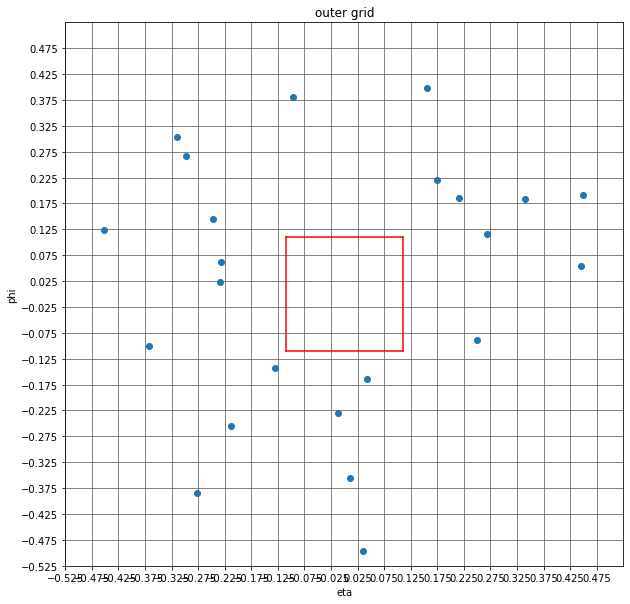

In [29]:
fig, ax = plt.subplots(1, figsize=(10, 10))

if grid_type != 'inner':
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_right['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_left['inner']], [grid_left['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_left['inner'], grid_left['inner']], 'r')
    ax.plot([grid_right['inner'], grid_right['inner']], [grid_left['inner'], grid_right['inner']], 'r')

ax.scatter(x=grid_coord['deta'], y=grid_coord['dphi'])

ax.set_xlim(grid_left[grid_type], grid_right[grid_type])
ax.set_ylim(grid_left[grid_type], grid_right[grid_type])
ax.set_xticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))
ax.set_yticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))

ax.set_xlabel('eta')
ax.set_ylabel('phi')
ax.set_title(f'{grid_type} grid')

plt.grid(b=True, which='major', color='#666666', linestyle='-') 

plt.show()

### fill final tensor

In [30]:
from transform_inputs import get_grid_mask, get_fill_indices, get_fill_values

In [31]:
fill_branches = {'ele': taus['ele'].fields[:37], # here just pick first 37
                 'muon': taus['muon'].fields[:37],
                 'pfCand': taus['pfCand'].fields[:37]                
                 } # branches to be stored

In [32]:
# initialize tensors to be filled 
grid_tensors = {key: {} for key in grid_types}
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_tensors[grid_type][c_type] = np.zeros((batch_size, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [33]:
# dictionaries to store timing
get_mask_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
get_fill_indices_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
get_fill_values_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
fill_tensor_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}

In [34]:
program_starts = time.time()
for c_type in constituent_types:
    # looping over grids
    for grid_type in grid_types:
        begin_iter = time.time()
        
        # fetch grid_mask
        grid_mask = get_grid_mask(taus, c_type, grid_type)
        after_get_mask = time.time()
        get_mask_times[grid_type][c_type].append(after_get_mask - begin_iter)
        
        # fetch grid indices to be filled
        indices_eta, indices_phi = get_fill_indices(taus, c_type, grid_type, grid_mask)
        after_get_fill_indices = time.time()
        get_fill_indices_times[grid_type][c_type].append(after_get_fill_indices - after_get_mask)
            
        # loop over taus in the batch
        for i_tau, tau in enumerate(taus):
            if i_tau%100 == 0:
                print(f'- {i_tau}th tau')
            if ak.sum(grid_mask[i_tau]) == 0:
                continue
            before_get_fill_values = time.time()
            
            # fetch indices
            i_eta, i_phi = indices_eta[i_tau], indices_phi[i_tau]
            
            # fetch values to be filled
            values_to_fill = get_fill_values(tau, c_type, fill_branches[c_type], grid_mask[i_tau])
            after_get_fill_values = time.time()
            get_fill_values_times[grid_type][c_type].append(after_get_fill_values - before_get_fill_values)
            
            # put them in the tensor
            grid_tensors[grid_type][c_type][i_tau, i_eta, i_phi, :] = values_to_fill
            after_put = time.time()
            fill_tensor_times[grid_type][c_type].append(after_put - after_get_fill_values)       
program_ends = time.time()

- 0th tau
- 100th tau
- 200th tau
- 0th tau
- 100th tau
- 200th tau
- 0th tau
- 100th tau
- 200th tau
- 0th tau
- 100th tau
- 200th tau
- 0th tau
- 100th tau
- 200th tau
- 0th tau
- 100th tau
- 200th tau


In [35]:
# # release memory
#     for grid_type in grid_types:
#         del grid_tensors[grid_type]
# gc.collect()

In [36]:
print(f'Processed {batch_size} taus in {program_ends - program_starts} seconds\n')
for c_type in constituent_types:
    print(f'=== {c_type}\n')
    for grid_type in grid_types:
        print(f'------- {grid_type} cell')
        print(f'median get_grid_mask() time: {np.median(get_mask_times[grid_type][c_type])}')
        print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type][c_type])}')
        print(f'median get_fill_values() time: {np.median(get_fill_values_times[grid_type][c_type])}')
        print(f'median fill tensor time: {np.median(fill_tensor_times[grid_type][c_type])}')
        print()
    print()

Processed 300 taus in 1.3787345886230469 seconds

=== ele

------- inner cell
median get_grid_mask() time: 0.00016498565673828125
median get_fill_indices() time: 0.0007960796356201172
median get_fill_values() time: 0.0015897750854492188
median fill tensor time: 0.0002789497375488281

------- outer cell
median get_grid_mask() time: 6.580352783203125e-05
median get_fill_indices() time: 0.0006067752838134766
median get_fill_values() time: 0.0011246204376220703
median fill tensor time: 0.00020897388458251953


=== muon

------- inner cell
median get_grid_mask() time: 4.00543212890625e-05
median get_fill_indices() time: 0.000461578369140625
median get_fill_values() time: 0.001029372215270996
median fill tensor time: 0.00018310546875

------- outer cell
median get_grid_mask() time: 4.315376281738281e-05
median get_fill_indices() time: 0.00045800209045410156
median get_fill_values() time: 0.0010364055633544922
median fill tensor time: 0.00019168853759765625


=== pfCand

------- inner cell
me

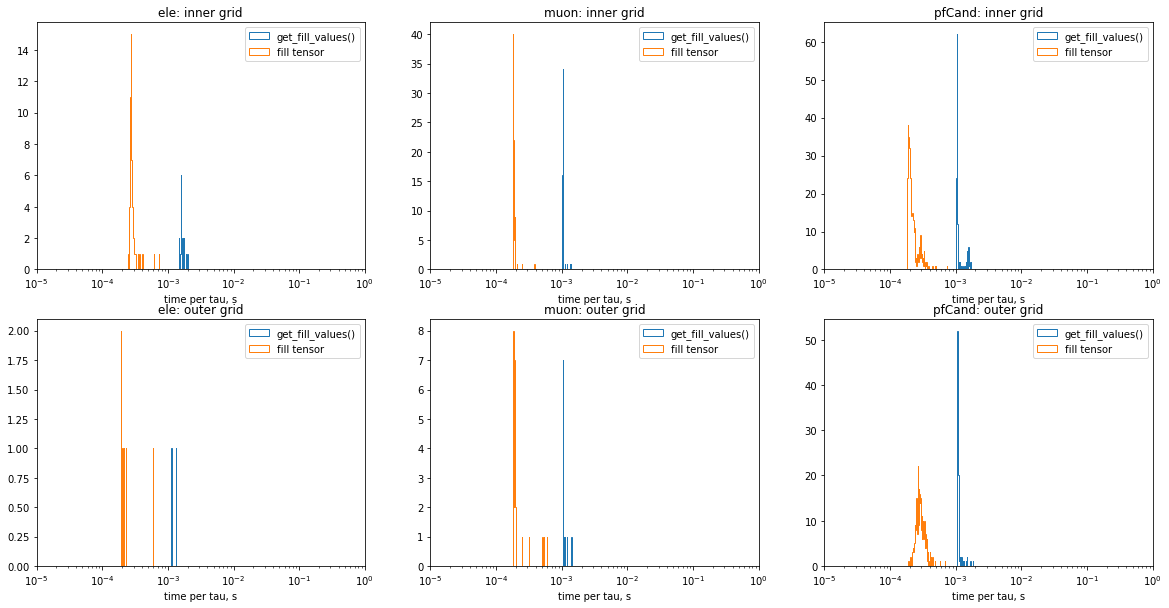

In [37]:
f, ax = plt.subplots(len(grid_types), len(constituent_types), figsize=(20,10))
for i, grid_type in enumerate(grid_types):
    for j, c_type in enumerate(constituent_types):
        ax[i,j].hist(get_fill_values_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_values()')
        ax[i,j].hist(fill_tensor_times[grid_type][c_type], histtype='step', bins=100, label='fill tensor')
        ax[i,j].set_xlabel('time per tau, s')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim((1e-5, 1e0))
        ax[i,j].set_title(f'{c_type}: {grid_type} grid')
        ax[i,j].legend()

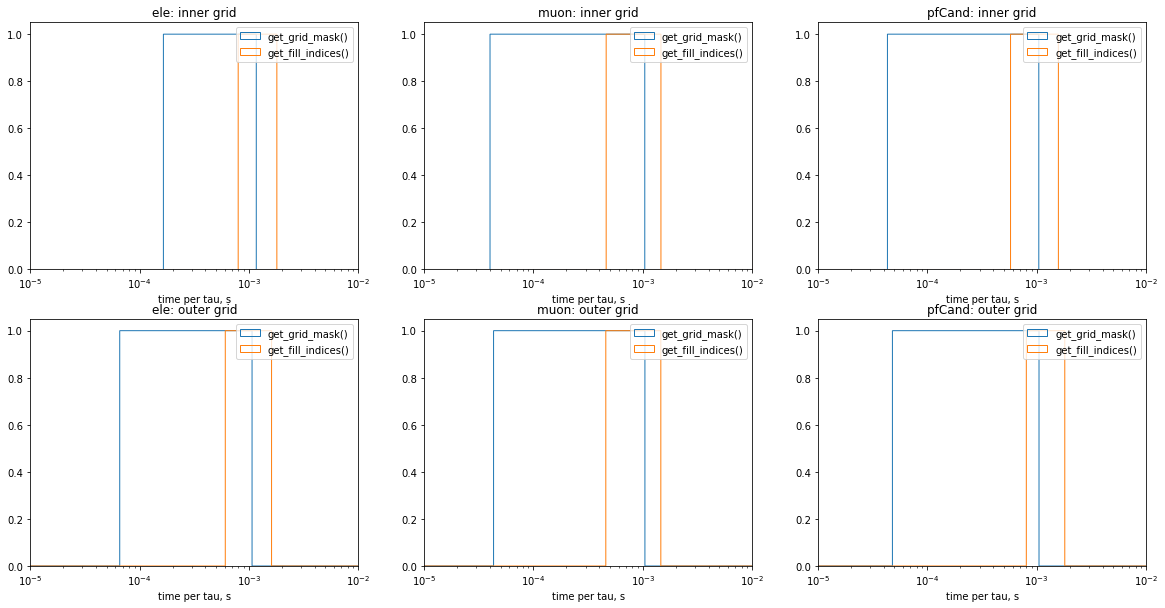

In [38]:
f, ax = plt.subplots(len(grid_types), len(constituent_types), figsize=(20,10))
for i, grid_type in enumerate(grid_types):
    for j, c_type in enumerate(constituent_types):
        ax[i,j].hist(get_mask_times[grid_type][c_type], histtype='step', bins=1000, label='get_grid_mask()')
        ax[i,j].hist(get_fill_indices_times[grid_type][c_type], histtype='step', bins=1000, label='get_fill_indices()')
        ax[i,j].set_xlabel('time per tau, s')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim((1e-5, 1e-2))
        ax[i,j].set_title(f'{c_type}: {grid_type} grid')
        ax[i,j].legend()

### validating final tensor

In [39]:
grid_type = 'inner'
c_type = 'pfCand'
tau_i = 10

In [40]:
grid_mask = taus[c_type, f'{grid_type}_grid_mask']
grid_coord = ak.to_pandas(taus[c_type, ['deta', 'dphi']][grid_mask][tau_i])
grid_coord

,deta,dphi
entry,,
0,-0.100162,-0.018256
1,0.000000,0.000000


In [59]:
feature_i = 29

In [60]:
eta_indices = taus[c_type, f"{grid_type}_grid_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[c_type, f"{grid_type}_grid_indices_phi"][grid_mask][tau_i].tolist()
vals = taus[c_type, fill_branches[c_type][feature_i]][grid_mask][tau_i]
for x,y,v in sorted(zip(eta_indices, phi_indices, vals)):
    print(x,y,v)

0.0 4.0 8.0
5.0 5.0 15.0


In [61]:
nonzero_idx_eta = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 0]
nonzero_idx_phi = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 1]
nonzero_vals = grid_tensors[grid_type][c_type][tau_i, nonzero_idx_eta, nonzero_idx_phi, feature_i]
for x,y,v in sorted(zip(nonzero_idx_eta, nonzero_idx_phi, nonzero_vals)):
    print(x,y,v)

0 4 8.0
5 5 15.0


### [dev] better way to convert to numpy

In [144]:
grid_type = 'outer'
c_type = 'pfCand'
tau_i = 20
branches = taus[c_type].fields[:50]

In [145]:
grid_mask = taus[c_type, f'{grid_type}_grid_mask']

In [146]:
tout = np.zeros((batch_size, n_cells[grid_type], n_cells[grid_type], len(branches)))

In [147]:
# vfill = (taus[c_type, branches][grid_mask][tau_i])
vfill = ak.to_numpy(taus[c_type, branches][grid_mask][tau_i]).tolist()
# vfill = ak.to_list(taus[c_type, branches][grid_mask][tau_i])

# vfill = vfill.astype(tuple)
# vfill = [list(v) for v in vfill]

In [148]:
%%timeit
ak.to_numpy(taus[c_type, branches][grid_mask][tau_i]).tolist()

1.24 ms ± 8.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [149]:
%%timeit
get_fill_values(taus[tau_i], c_type, branches, grid_mask[tau_i])

1.88 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [143]:
tout[tau_i, [1,2], [1,2], :] = vfill

ValueError: shape mismatch: value array of shape (21,42) could not be broadcast to indexing result of shape (2,42)

In [114]:
vfill.tolist()

list

In [166]:
def transform_to_list(a):
    return list(a)

In [167]:
vtransform_to_list = np.vectorize(transform_to_list)

In [176]:
%%timeit
np.apply_along_axis(lambda v: list(v), 0, vfill)

60.5 µs ± 330 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [173]:
%%timeit
[list(c) for c in vfill]

666 µs ± 2.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
max_constituent = max(ak.num(taus[]))

In [ ]:
ak.pad_none()

In [175]:
ak.to_numpy(taus[c_type, fill_branches[c_type]])

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.0.1/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

### [dev] vectorize over tau

* pad values to fill onto the whole grid (that is, remove jaggedness)
    * append indices which are not "for filling"
    * append corresponding arrays of zeros to `values_to_fill`

In [109]:
grid_type = 'inner'
c_type = 'pfCand'
tau_i = 10

In [110]:
tout = np.zeros((batch_size, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [113]:
len(values_to_fill)

23

### [dev] numba

In [ ]:
# play around numba here

### some ideas

-> can also try on GPU since awkward supports it, might be faster 